In [1]:
import scipy
import scipy.sparse as sp
import numpy as np
import pandas as pd
import plotly.plotly as py
from string import maketrans, punctuation
import random
from time import time
import re

#import visplots

from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

#############################
### Matplotlib
import matplotlib.pyplot as plt # module for plotting 
from matplotlib import interactive, font_manager
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

#############################

from sklearn import metrics, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from scipy.stats.distributions import randint
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, KFold
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import normalize, Normalizer
#from sklearn.pipeline import Pipeline, make_pipeline

import nltk
from nltk.corpus import stopwords


init_notebook_mode()
%matplotlib inline 
print ("Required Libraries loaded.")

Required Libraries loaded.


In [2]:
# Import the data and explore the first few rows

inhibitor  = pd.read_csv("C:\EPC_Data\TREC_BROKEN\No_Mh_Tag/skeletalMuscleRelaxants_no_mh.csv", sep=",")
header = inhibitor.columns.values
inhibitor.head()

,PMID,Label,TIABSMh
0,10423584,0,Alpha 2agonist versus alpha 1antagonist in mil...
1,10541228,0,Treatment of cerebral origin spasticity with c...
2,10545555,0,Managing pediatric epilepsy syndromes with new...
3,10547405,0,A comparison of osteopathic spinal manipulatio...
4,10551442,0,Zanamivir: a review of its use in influenza.Za...


In [3]:
seed = 29
# shuffle dataset and split to train and test
x = shuffle(inhibitor, random_state = seed)
x.head()

,PMID,Label,TIABSMh
555,12391445,0,Spasticity.NAHuman Human Muscle Relaxants ...
135,10985996,0,Periodic lateralized epileptiform discharges: ...
30,10614570,0,Postictal psychosis in a child.Postictal psych...
1452,9242233,0,Recent advancements in epilepsy.This article r...
144,11029681,0,Treatment of fibromyalgia with antidepressants...


In [4]:
x.TIABSMh =  x.TIABSMh.str.replace(r'[^a-zA-Z\s]',' ')
Test_Size = 0.25

#split to test and train
x_train, x_test, y_train, y_test = train_test_split(x.TIABSMh, x.Label, test_size = Test_Size, random_state = 27)

In [5]:
# Print the 1st row and 1st column of npArray
print (x_train.shape)
print (x_test.shape)

yFreq = scipy.stats.itemfreq(x.Label)
print("Overall class distribution: \n", yFreq)

# Print the y frequencies
yFreq = scipy.stats.itemfreq(y_train)
print("Train set distribution: \n", yFreq)

yFreq = scipy.stats.itemfreq(y_test)
print("\nTest set distribution: \n", yFreq)

(1207L,)
(403L,)
('Overall class distribution: \n', array([[   0, 1601],
       [   1,    9]], dtype=int64))
('Train set distribution: \n', array([[   0, 1201],
       [   1,    6]], dtype=int64))
('\nTest set distribution: \n', array([[  0, 400],
       [  1,   3]], dtype=int64))


In [6]:
# preprocess data
def binvec(xtr, xte):
    print("Extracting features from the dataset using a sparse vectorizer")
    t0 = time()
    bin_vectorizer = TfidfVectorizer(stop_words = 'english', max_df=0.8, min_df = 2, binary = True, 
                                     use_idf = False, norm = None)
    xtr = bin_vectorizer.fit_transform(xtr)
    xte = bin_vectorizer.transform(xte)
    print("done in %fs" % (time() - t0))
    return xtr, xte

def tfidfvec(xtr, xte):
    print("Extracting features from the dataset using a sparse vectorizer")
    t0 = time()
    tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', max_df=0.8, min_df = 2, binary = False, 
                                       use_idf = True, smooth_idf = True, norm = 'l2')
    xtr = tfidf_vectorizer.fit_transform(xtr)
    xte = tfidf_vectorizer.transform(xte)
    print("done in %fs" % (time() - t0))
    return xtr, xte


def tfvec(xtr, xte):
    print("Extracting features from the dataset using a sparse vectorizer")
    t0 = time()
    tf_vectorizer = TfidfVectorizer(stop_words = 'english', max_df=0.8, min_df = 2, binary = False, 
                                    use_idf = False, smooth_idf = False, norm = 'l2')
    xtr = tf_vectorizer.fit_transform(xtr)
    xte = tf_vectorizer.transform(xte)
    print("done in %fs" % (time() - t0))
    return xtr, xte


bin_Xtrain, bin_Xtest = binvec(x_train, x_test)
tfidf_Xtrain, tfidf_Xtest = tfidfvec(x_train, x_test)
tf_Xtrain, tf_Xtest = tfvec(x_train, x_test)

print("n_samples: %d, n_features: %d" % bin_Xtrain.shape)
print("n_samples: %d, n_features: %d" % tfidf_Xtrain.shape)
print("n_samples: %d, n_features: %d" % tf_Xtrain.shape)
assert sp.issparse(bin_Xtrain)
assert sp.issparse(tfidf_Xtrain)
assert sp.issparse(tf_Xtrain)


print("n_samples: %d, n_features: %d" % bin_Xtest.shape)
print("n_samples: %d, n_features: %d" % tfidf_Xtest.shape)
print("n_samples: %d, n_features: %d" % tf_Xtest.shape)

Extracting features from the dataset using a sparse vectorizer
done in 0.343000s
Extracting features from the dataset using a sparse vectorizer
done in 0.390000s
Extracting features from the dataset using a sparse vectorizer
done in 0.374000s
n_samples: 1207, n_features: 6960
n_samples: 1207, n_features: 6960
n_samples: 1207, n_features: 6960
n_samples: 403, n_features: 6960
n_samples: 403, n_features: 6960
n_samples: 403, n_features: 6960


In [7]:
def ch2(xtr, ytr, xte):
    ch = SelectKBest(chi2, k=4000)
    xtrain = ch.fit_transform(xtr, ytr)
    xtest = ch.transform(xte)
    return xtrain, xtest


bin_Xtrain, bin_Xtest = ch2(bin_Xtrain, y_train, bin_Xtest)
tfidf_Xtrain, tfidf_Xtest = ch2(tfidf_Xtrain, y_train, tfidf_Xtest)
tf_Xtrain, tf_Xtest = ch2(tf_Xtrain, y_train, tf_Xtest)

In [8]:
def weight(x):
    x = np.where(x==0, 1, 4)
    return x 

Training and test datasets created
SVM with Linear kernel C=1.0
________________________________________________________________________________
Training: 
SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=55, shrinking=True,
  tol=0.001, verbose=False)
train time: 0.093s
test time:  0.031s
accuracy:   0.993
precision:  0.000
recall:     0.000
('Complexity: ', array([115,   6]))
*** AUC for ROC = 0.504

classification report:
             precision    recall  f1-score   support

 Irrelevant       0.99      1.00      1.00       400
   Relevant       0.00      0.00      0.00         3

avg / total       0.99      0.99      0.99       403

confusion matrix:
[[400   0]
 [  3   0]]
()
SVM with Linear kernel C=10.0
________________________________________________________________________________
Training: 
SVC(C=10.0, cache_size=200, class_weight='balanced', coe

C:\Users\raylite\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

C:\Users\raylite\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



train time: 0.094s
test time:  0.031s
accuracy:   0.993
precision:  0.000
recall:     0.000
('Complexity: ', array([115,   6]))
*** AUC for ROC = 0.504

classification report:
             precision    recall  f1-score   support

 Irrelevant       0.99      1.00      1.00       400
   Relevant       0.00      0.00      0.00         3

avg / total       0.99      0.99      0.99       403

confusion matrix:
[[400   0]
 [  3   0]]
()
SVM with Linear kernel C=100
________________________________________________________________________________
Training: 
SVC(C=100.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=55, shrinking=True,
  tol=0.001, verbose=False)
train time: 0.093s
test time:  0.032s
accuracy:   0.993
precision:  0.000
recall:     0.000
('Complexity: ', array([115,   6]))
*** AUC for ROC = 0.504

classification report:
             precision    recall  f

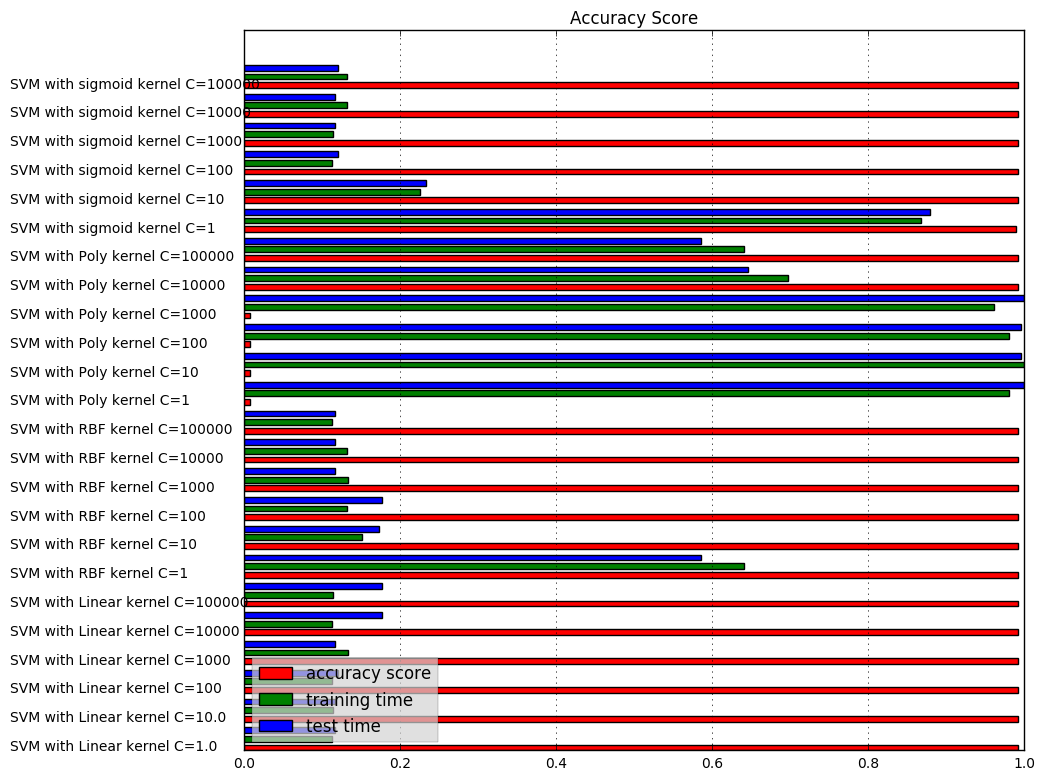

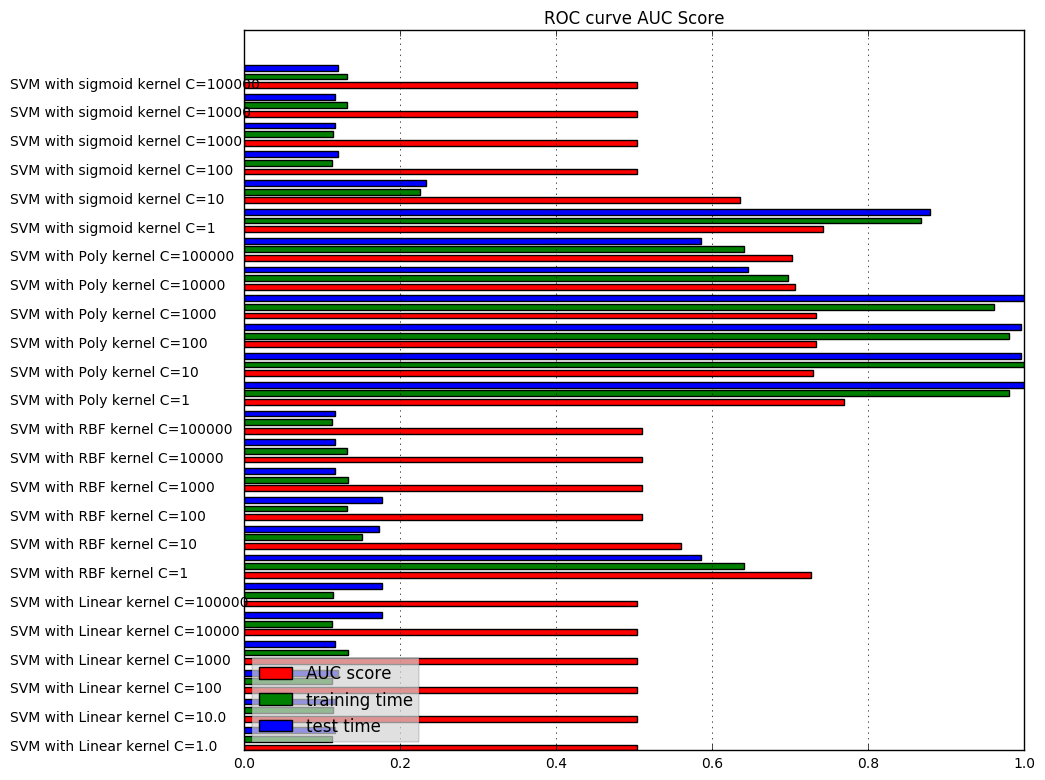

In [9]:
##  based on this SciKitLearn example:
# http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html

# options
print_report = True
print_cm = True
print_top10 = True
n_features = 2 ** 16
filtered = True
RANDOM_STATE = 55

########


sw_train = weight(y_train)

categories = ['Irrelevant', 'Relevant']
print('Training and test datasets created')

def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


########
# Benchmark the classifiers, one at a time
def benchmark(bin_clf, name):
    """
    clf - the classifier
    name - its name
    
    benchmark: to create the benchmark metrics for the classification
    returns: the inputs to the results list
    """
    print('_' * 80)
    print("Training: ")
    print(bin_clf)
    t0 = time()
    try:
        bin_clf.fit(bin_Xtrain, y_train, sample_weight = sw_train)#with weight
    except:
        bin_clf.fit(bin_Xtrain, y_train)#no weight
        
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = bin_clf.predict(bin_Xtest)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)
    
    
    acc_score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % acc_score)
    
    prec_score = metrics.precision_score(y_test, pred)
    print("precision:  %0.3f" % prec_score)
    
    recall = metrics.recall_score(y_test, pred)
    print("recall:     %0.3f" % recall)
    
    # get the decision boundary or the probas.
    if hasattr(bin_clf, "decision_function"):
        y_score = np.array(bin_clf.decision_function(bin_Xtest))
    else:
        y_score = bin_clf.predict_proba(bin_Xtest)[:,1]
        
    if hasattr(bin_clf, "n_support_"):
        print ("Complexity: ", bin_clf.n_support_)
    
    
    auc_score = metrics.roc_auc_score(y_test, y_score)
    print("*** AUC for ROC = %0.3f\n" % auc_score)
    
    #if hasattr(clf, 'coef_'):
    #    print("dimensionality: %d" % clf.coef_.shape[1])
    #    print("density: %f" % density(clf.coef_))
    #    print()

    if print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred, target_names=categories))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(bin_clf).split('(')[0]
    return name, acc_score, auc_score, prec_score, recall, train_time, test_time

def create_results():
    """
    create_results: to run the classification and create the of results 
    from the battery of classifiers
    returns: an multiD list of results
    """
    results = []
    for clf, name in (
            (SVC(kernel="linear", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=1.0"),
            (SVC(kernel="linear", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=10.0"),
            (SVC(kernel="linear", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=100"),
            (SVC(kernel="linear", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=1000"),
            (SVC(kernel="linear", C=10000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=10000"),
            (SVC(kernel="linear", C=100000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=100000"),
            (SVC(kernel="rbf", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=1"),
            (SVC(kernel="rbf", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=10"),
            (SVC(kernel="rbf", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=100"),
            (SVC(kernel="rbf", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=1000"),
            (SVC(kernel="rbf", C=10000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=10000"),
            (SVC(kernel="rbf", C=100000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=100000"),
            (SVC(kernel="poly", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=1"),
            (SVC(kernel="poly", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=10"),
            (SVC(kernel="poly", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=100"),
            (SVC(kernel="poly", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=1000"),
            (SVC(kernel="poly", C=10000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=10000"),
            (SVC(kernel="poly", C=100000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=100000"),
            (SVC(kernel="sigmoid", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=1"),
            (SVC(kernel="sigmoid", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=10"),
            (SVC(kernel="sigmoid", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=100"),
            (SVC(kernel="sigmoid", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=1000"),
            (SVC(kernel="sigmoid", C=10000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=10000"),
            (SVC(kernel="sigmoid", C=100000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=100000")            ):
        print('=' * 80)
        print(name)
        results.append(benchmark(clf, name))
    return results
    

def comparison_plots(results):
    """
    results - array containing the results from the classification to plot
    
    yields: prints out the results from each classifier and then finishes with plots of the 
    accuracy scores and ROC AUC scores for all the classifiers
    """
    
   
    ######
    # make some plots

    indices = np.arange(len(results))

    results = [[x[i] for x in results] for i in range(7)]

    clf_names, acc_score, auc_score, prec_score, recall, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    ######
    #  Make a plot for the accuracy scores 
    plt.figure(figsize=(12, 8))
    plt.title("Accuracy Score")
    plt.barh(indices, acc_score, .2, label="accuracy score", color='r')
    plt.barh(indices + .3, training_time, .2, label="training time", color='g')
    plt.barh(indices + .6, test_time, .2, label="test time", color='b')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)
    legend = plt.legend(loc=3,frameon=True,framealpha=0.7)
    rect = legend.get_frame()
    rect.set_facecolor('lightgray')
    rect.set_linewidth(0.2)
    plt.gca().xaxis.grid(True)
    #remove_border()

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)

    plt.show()
    
    ######
    #  Make a plot for the ROC curve AUC scores 
    plt.figure(figsize=(12, 8))
    plt.title("ROC curve AUC Score")
    plt.barh(indices, auc_score, .2, label="AUC score", color='r')
    plt.barh(indices + .3, training_time, .2, label="training time", color='g')
    plt.barh(indices + .6, test_time, .2, label="test time", color='b')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)
    legend = plt.legend(loc=3,frameon=True,framealpha=0.7)
    rect = legend.get_frame()
    rect.set_facecolor('lightgray')
    rect.set_linewidth(0.2)
    plt.gca().xaxis.grid(True)
    #remove_border()
    

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)
    plt.show()
    
# run the comparision of the battery of classifiers and plot out the results
comparison_plots(create_results())

Training and test datasets created
SVM with Linear kernel C=1.0
________________________________________________________________________________
Training: 
SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=55, shrinking=True,
  tol=0.001, verbose=False)
train time: 0.080s
test time:  0.032s
accuracy:   0.993
precision:  0.000
recall:     0.000
('Complexity: ', array([83,  6]))
*** AUC for ROC = 0.552

classification report:
             precision    recall  f1-score   support

 Irrelevant       0.99      1.00      1.00       400
   Relevant       0.00      0.00      0.00         3

avg / total       0.99      0.99      0.99       403

confusion matrix:
[[400   0]
 [  3   0]]
()
SVM with Linear kernel C=10.0
________________________________________________________________________________
Training: 
SVC(C=10.0, cache_size=200, class_weight='balanced', coef0

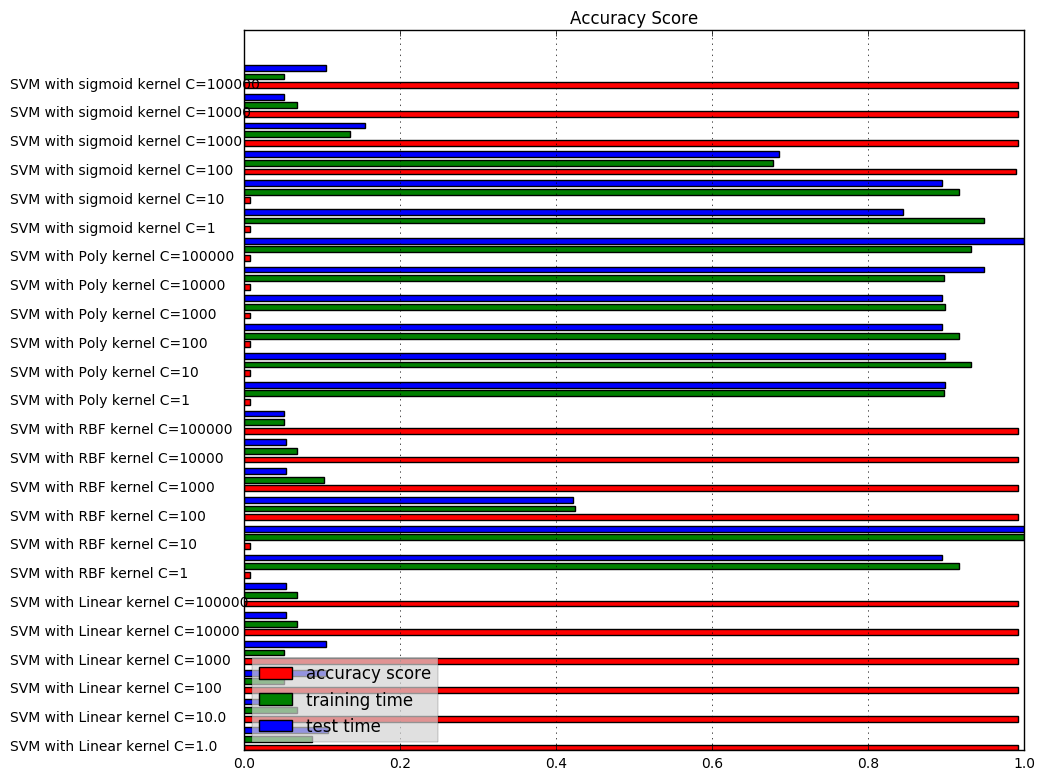

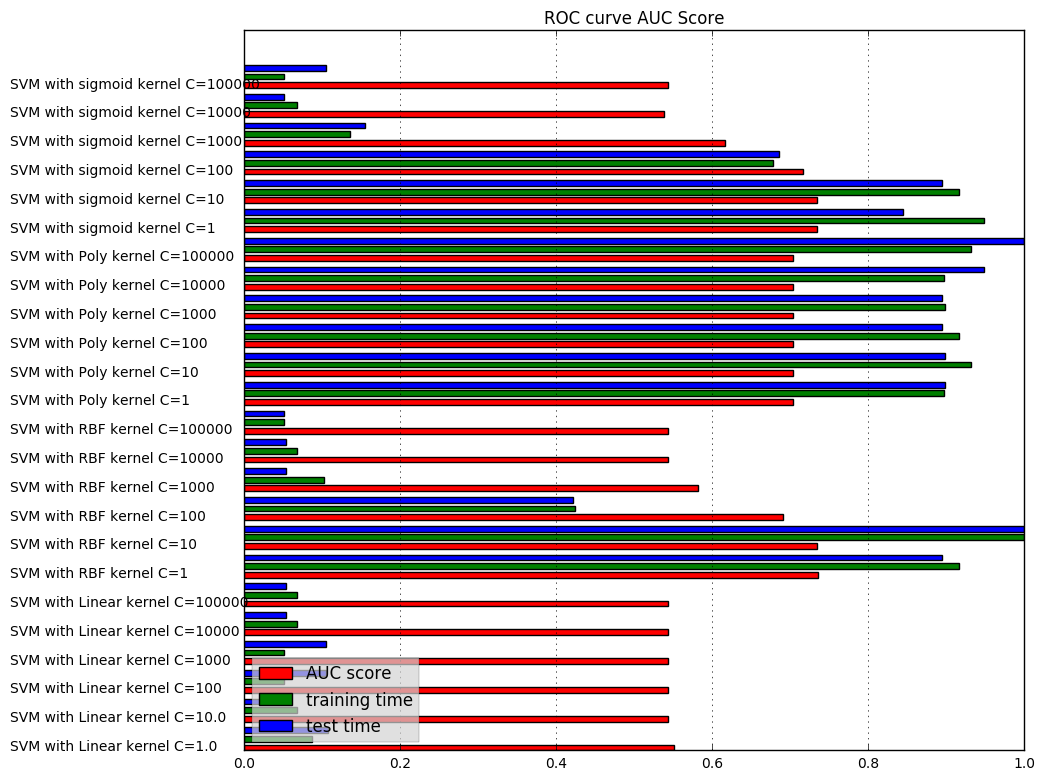

In [10]:
##  based on this SciKitLearn example:
# http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html

# options
print_report = True
print_cm = True
print_top10 = True
n_features = 2 ** 16
filtered = True
RANDOM_STATE = 55

########


sw_train = weight(y_train)

categories = ['Irrelevant', 'Relevant']
print('Training and test datasets created')

def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


########
# Benchmark the classifiers, one at a time
def benchmark(tfidf_clf, name):
    """
    clf - the classifier
    name - its name
    
    benchmark: to create the benchmark metrics for the classification
    returns: the inputs to the results list
    """
    print('_' * 80)
    print("Training: ")
    print(tfidf_clf)
    t0 = time()
    try:
        tfidf_clf.fit(tfidf_Xtrain, y_train, sample_weight = sw_train)#with weight
    except:
        tfidf_clf.fit(tfidf_Xtrain, y_train)#no weight
        
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = tfidf_clf.predict(tfidf_Xtest)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)
    
    
    acc_score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % acc_score)
    
    prec_score = metrics.precision_score(y_test, pred)
    print("precision:  %0.3f" % prec_score)
    
    recall = metrics.recall_score(y_test, pred)
    print("recall:     %0.3f" % recall)
    
    # get the decision boundary or the probas.
    if hasattr(tfidf_clf, "decision_function"):
        y_score = np.array(tfidf_clf.decision_function(tfidf_Xtest))
    else:
        y_score = tfidf_clf.predict_proba(tfidf_Xtest)[:,1]
        
    if hasattr(tfidf_clf, "n_support_"):
        print ("Complexity: ", tfidf_clf.n_support_)
    
    
    auc_score = metrics.roc_auc_score(y_test, y_score)
    print("*** AUC for ROC = %0.3f\n" % auc_score)
    
    #if hasattr(clf, 'coef_'):
    #    print("dimensionality: %d" % clf.coef_.shape[1])
    #    print("density: %f" % density(clf.coef_))
    #    print()

    if print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred, target_names=categories))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(tfidf_clf).split('(')[0]
    return name, acc_score, auc_score, prec_score, recall, train_time, test_time

def create_results():
    """
    create_results: to run the classification and create the of results 
    from the battery of classifiers
    returns: an multiD list of results
    """
    results = []
    for clf, name in (
            (SVC(kernel="linear", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=1.0"),
            (SVC(kernel="linear", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=10.0"),
            (SVC(kernel="linear", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=100"),
            (SVC(kernel="linear", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=1000"),
            (SVC(kernel="linear", C=10000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=10000"),
            (SVC(kernel="linear", C=100000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=100000"),
            (SVC(kernel="rbf", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=1"),
            (SVC(kernel="rbf", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=10"),
            (SVC(kernel="rbf", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=100"),
            (SVC(kernel="rbf", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=1000"),
            (SVC(kernel="rbf", C=10000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=10000"),
            (SVC(kernel="rbf", C=100000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=100000"),
            (SVC(kernel="poly", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=1"),
            (SVC(kernel="poly", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=10"),
            (SVC(kernel="poly", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=100"),
            (SVC(kernel="poly", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=1000"),
            (SVC(kernel="poly", C=10000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=10000"),
            (SVC(kernel="poly", C=100000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=100000"),
            (SVC(kernel="sigmoid", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=1"),
            (SVC(kernel="sigmoid", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=10"),
            (SVC(kernel="sigmoid", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=100"),
            (SVC(kernel="sigmoid", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=1000"),
            (SVC(kernel="sigmoid", C=10000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=10000"),
            (SVC(kernel="sigmoid", C=100000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=100000")            ):
        print('=' * 80)
        print(name)
        results.append(benchmark(clf, name))
    return results
    

def comparison_plots(results):
    """
    results - array containing the results from the classification to plot
    
    yields: prints out the results from each classifier and then finishes with plots of the 
    accuracy scores and ROC AUC scores for all the classifiers
    """
    
   
    ######
    # make some plots

    indices = np.arange(len(results))

    results = [[x[i] for x in results] for i in range(7)]

    clf_names, acc_score, auc_score, prec_score, recall, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    ######
    #  Make a plot for the accuracy scores 
    plt.figure(figsize=(12, 8))
    plt.title("Accuracy Score")
    plt.barh(indices, acc_score, .2, label="accuracy score", color='r')
    plt.barh(indices + .3, training_time, .2, label="training time", color='g')
    plt.barh(indices + .6, test_time, .2, label="test time", color='b')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)
    legend = plt.legend(loc=3,frameon=True,framealpha=0.7)
    rect = legend.get_frame()
    rect.set_facecolor('lightgray')
    rect.set_linewidth(0.2)
    plt.gca().xaxis.grid(True)
    #remove_border()

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)

    plt.show()
    
    ######
    #  Make a plot for the ROC curve AUC scores 
    plt.figure(figsize=(12, 8))
    plt.title("ROC curve AUC Score")
    plt.barh(indices, auc_score, .2, label="AUC score", color='r')
    plt.barh(indices + .3, training_time, .2, label="training time", color='g')
    plt.barh(indices + .6, test_time, .2, label="test time", color='b')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)
    legend = plt.legend(loc=3,frameon=True,framealpha=0.7)
    rect = legend.get_frame()
    rect.set_facecolor('lightgray')
    rect.set_linewidth(0.2)
    plt.gca().xaxis.grid(True)
    #remove_border()
    

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)
    plt.show()
    
# run the comparision of the battery of classifiers and plot out the results
comparison_plots(create_results())

Training and test datasets created
SVM with Linear kernel C=1.0
________________________________________________________________________________
Training: 
SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=55, shrinking=True,
  tol=0.001, verbose=False)
train time: 0.093s
test time:  0.016s
accuracy:   0.993
precision:  0.000
recall:     0.000
('Complexity: ', array([77,  6]))
*** AUC for ROC = 0.568

classification report:
             precision    recall  f1-score   support

 Irrelevant       0.99      1.00      1.00       400
   Relevant       0.00      0.00      0.00         3

avg / total       0.99      0.99      0.99       403

confusion matrix:
[[400   0]
 [  3   0]]
()
SVM with Linear kernel C=10.0
________________________________________________________________________________
Training: 
SVC(C=10.0, cache_size=200, class_weight='balanced', coef0

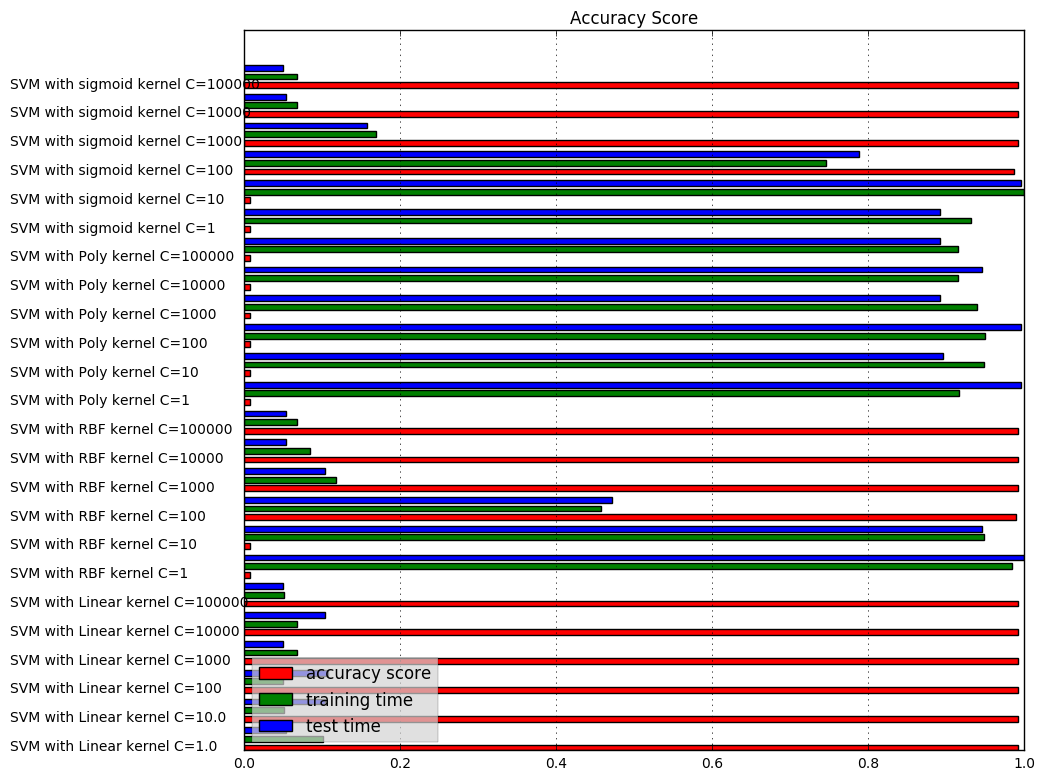

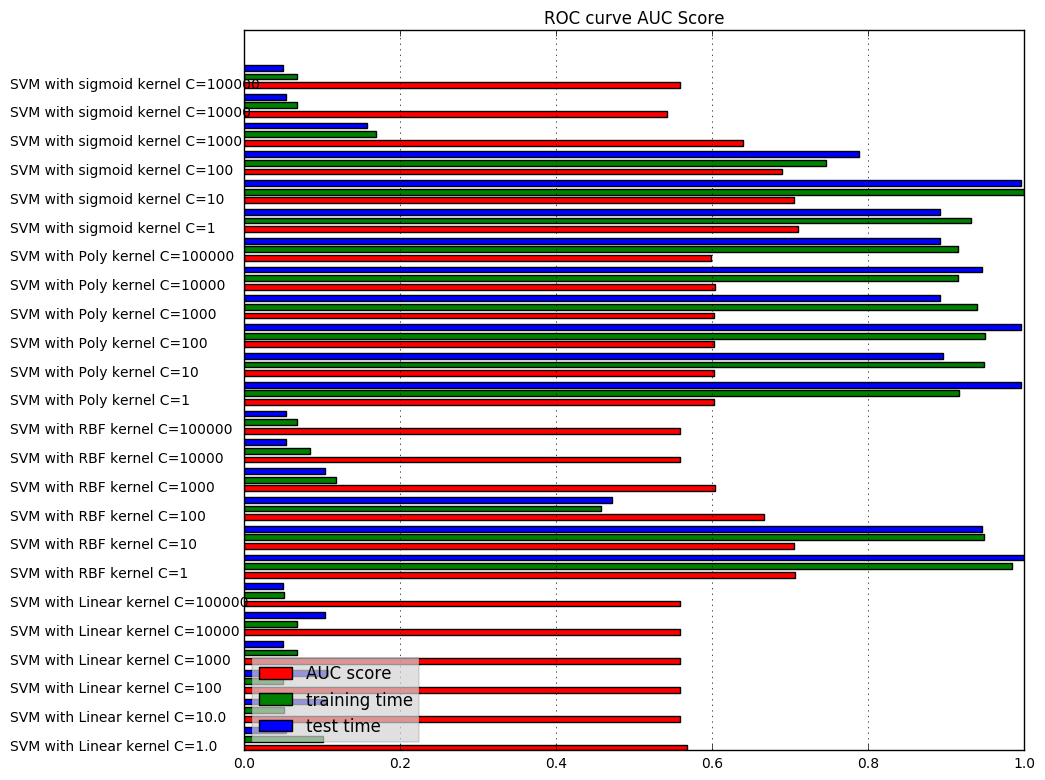

In [11]:
##  based on this SciKitLearn example:
# http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html
#TF model
# options
print_report = True
print_cm = True
print_top10 = True
n_features = 2 ** 16
filtered = True
RANDOM_STATE = 55

########


sw_train = weight(y_train)

categories = ['Irrelevant', 'Relevant']
print('Training and test datasets created')

def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


########
# Benchmark the classifiers, one at a time
def benchmark(tf_clf, name):
    """
    clf - the classifier
    name - its name
    
    benchmark: to create the benchmark metrics for the classification
    returns: the inputs to the results list
    """
    print('_' * 80)
    print("Training: ")
    print(tf_clf)
    t0 = time()
    try:
        tf_clf.fit(tf_Xtrain, y_train, sample_weight = sw_train)#with weight
    except:
        tf_clf.fit(tf_Xtrain, y_train)#no weight
        
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = tf_clf.predict(tf_Xtest)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)
    
    
    acc_score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % acc_score)
    
    prec_score = metrics.precision_score(y_test, pred)
    print("precision:  %0.3f" % prec_score)
    
    recall = metrics.recall_score(y_test, pred)
    print("recall:     %0.3f" % recall)
    
    # get the decision boundary or the probas.
    if hasattr(tf_clf, "decision_function"):
        y_score = np.array(tf_clf.decision_function(tf_Xtest))
    else:
        y_score = tf_clf.predict_proba(tf_Xtest)[:,1]
        
    if hasattr(tf_clf, "n_support_"):
        print ("Complexity: ", tf_clf.n_support_)
    
    
    auc_score = metrics.roc_auc_score(y_test, y_score)
    print("*** AUC for ROC = %0.3f\n" % auc_score)
    
    #if hasattr(clf, 'coef_'):
    #    print("dimensionality: %d" % clf.coef_.shape[1])
    #    print("density: %f" % density(clf.coef_))
    #    print()

    if print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred, target_names=categories))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(tf_clf).split('(')[0]
    return name, acc_score, auc_score, prec_score, recall, train_time, test_time

def create_results():
    """
    create_results: to run the classification and create the of results 
    from the battery of classifiers
    returns: an multiD list of results
    """
    results = []
    for clf, name in (
            (SVC(kernel="linear", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=1.0"),
            (SVC(kernel="linear", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=10.0"),
            (SVC(kernel="linear", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=100"),
            (SVC(kernel="linear", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=1000"),
            (SVC(kernel="linear", C=10000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=10000"),
            (SVC(kernel="linear", C=100000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=100000"),
            (SVC(kernel="rbf", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=1"),
            (SVC(kernel="rbf", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=10"),
            (SVC(kernel="rbf", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=100"),
            (SVC(kernel="rbf", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=1000"),
            (SVC(kernel="rbf", C=10000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=10000"),
            (SVC(kernel="rbf", C=100000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=100000"),
            (SVC(kernel="poly", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=1"),
            (SVC(kernel="poly", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=10"),
            (SVC(kernel="poly", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=100"),
            (SVC(kernel="poly", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=1000"),
            (SVC(kernel="poly", C=10000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=10000"),
            (SVC(kernel="poly", C=100000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=100000"),
            (SVC(kernel="sigmoid", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=1"),
            (SVC(kernel="sigmoid", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=10"),
            (SVC(kernel="sigmoid", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=100"),
            (SVC(kernel="sigmoid", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=1000"),
            (SVC(kernel="sigmoid", C=10000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=10000"),
            (SVC(kernel="sigmoid", C=100000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=100000")            ):
        print('=' * 80)
        print(name)
        results.append(benchmark(clf, name))
    return results
    

def comparison_plots(results):
    """
    results - array containing the results from the classification to plot
    
    yields: prints out the results from each classifier and then finishes with plots of the 
    accuracy scores and ROC AUC scores for all the classifiers
    """
    
   
    ######
    # make some plots

    indices = np.arange(len(results))

    results = [[x[i] for x in results] for i in range(7)]

    clf_names, acc_score, auc_score, prec_score, recall, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    ######
    #  Make a plot for the accuracy scores 
    plt.figure(figsize=(12, 8))
    plt.title("Accuracy Score")
    plt.barh(indices, acc_score, .2, label="accuracy score", color='r')
    plt.barh(indices + .3, training_time, .2, label="training time", color='g')
    plt.barh(indices + .6, test_time, .2, label="test time", color='b')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)
    legend = plt.legend(loc=3,frameon=True,framealpha=0.7)
    rect = legend.get_frame()
    rect.set_facecolor('lightgray')
    rect.set_linewidth(0.2)
    plt.gca().xaxis.grid(True)
    #remove_border()

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)

    plt.show()
    
    ######
    #  Make a plot for the ROC curve AUC scores 
    plt.figure(figsize=(12, 8))
    plt.title("ROC curve AUC Score")
    plt.barh(indices, auc_score, .2, label="AUC score", color='r')
    plt.barh(indices + .3, training_time, .2, label="training time", color='g')
    plt.barh(indices + .6, test_time, .2, label="test time", color='b')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)
    legend = plt.legend(loc=3,frameon=True,framealpha=0.7)
    rect = legend.get_frame()
    rect.set_facecolor('lightgray')
    rect.set_linewidth(0.2)
    plt.gca().xaxis.grid(True)
    #remove_border()
    

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)
    plt.show()
    
# run the comparision of the battery of classifiers and plot out the results
comparison_plots(create_results())

In [12]:
#!pip install --upgrade version_information
#%reload_ext version_information
%load_ext version_information 
%version_information scipy, numpy, sklearn, pandas, scipy, nltk, matplotlib

Software,Version
Python,2.7.13 64bit [MSC v.1500 64 bit (AMD64)]
IPython,5.1.0
OS,Windows 7 6.1.7601 SP1
scipy,0.18.1
numpy,1.11.2
sklearn,0.18.1
pandas,0.18.1
scipy,0.18.1
nltk,3.2.1
matplotlib,1.5.3


In [19]:
##best BINARY configuration
clf = SVC(C=10.0, cache_size=200, class_weight='balanced', coef0=0.0,decision_function_shape=None, degree=3, 
          gamma='auto', kernel='rbf', max_iter=-1, probability=False, random_state=55, shrinking=True,
          tol=0.001, verbose=False)

seeds = [35, 71, 21, 61, 55]

svm_precision = []
svm_recall = []
svm_f = []
acc = []
ps_vectors = []
ns_vectors = []
tr_pos = []
tr_neg = []
te_pos = []
te_neg = []
true_pos = []
true_neg = []
false_pos = []
false_neg = []


for seed in seeds:
    x_train, x_test, y_train, y_test = train_test_split(x.TIABSMh, x.Label, test_size = Test_Size, random_state = seed)
    X_train, X_test = binvec(x_train, x_test)
    X_train, X_test = ch2(X_train, y_train, X_test)
    
    w = weight(y_train)

    yTrFreq = scipy.stats.itemfreq(y_train)
    tr_pos = np.append(tr_pos, yTrFreq[1][1])
    tr_neg = np.append(tr_neg, yTrFreq[0][1])

    # print(yTrFreq)

    yTrFreq = scipy.stats.itemfreq(y_test)
    te_pos = np.append(te_pos, yTrFreq[1][1])
    te_neg = np.append(te_neg, yTrFreq[0][1])

    #print(yTrFreq)

    print ("Fitting for Seed = %d" % seed)  

    clf.fit(X_train, y_train, sample_weight = w)

    pred = clf.predict(X_test)

    s_vector = clf.n_support_
    print ("Support vectors: ", s_vector)            

    s_prec = metrics.precision_score(y_test, pred)#, sample_weight=wt)
    s_recall = metrics.recall_score(y_test, pred)#, sample_weight=wt)
    s_f1 = metrics.f1_score(y_test, pred)#, sample_weight=wt)
    
    print (metrics.confusion_matrix(y_test, pred))
    true_neg.append(metrics.confusion_matrix(y_test, pred)[0,0])
    true_pos.append(metrics.confusion_matrix(y_test, pred)[1,1])
    false_neg.append(metrics.confusion_matrix(y_test, pred)[1, 0])
    false_pos.append(metrics.confusion_matrix(y_test, pred)[0, 1])

    acc_s = metrics.accuracy_score(y_test, pred)
    svm_precision.append(s_prec)
    svm_recall.append(s_recall)
    svm_f.append(s_f1)
    acc.append(acc_s)
    ps_vectors = np.append(ps_vectors, s_vector[1])
    ns_vectors = np.append(ns_vectors, s_vector[0])      

print ("SVM Cross validation results: ")
print ("Mean Precision: %.2f +/- %.2f "%(np.mean(svm_precision), np.std(svm_precision)))
print ("  Mean  Recall: %.2f +/- %.2f" %(np.mean(svm_recall), np.std(svm_recall)))
print ("      Mean  F1: %.2f +/- %.2f" %(np.mean(svm_f), np.std(svm_f)))
print ("Mean  Accuracy: %.2f +/- %.2f" %(np.mean(acc), np.std(acc)))
print (" True Negative: ", true_neg)
print ("False Negative: ", false_neg)
print (" True Positive: ", true_pos)
print ("False Positive: ", false_pos)
print ("Negative support Vectors: ", ns_vectors)
print ("Positive support Vectors: ", ps_vectors)
print ("Mean positive support vectors: %.2f +/- %.2f"%(np.mean(ps_vectors), np.std(ps_vectors)))
print ("Mean Negative support vectors: %.2f +/- %.2f"%(np.mean(ns_vectors), np.std(ns_vectors)))
print ("Train positive: %.2f" %(np.mean(tr_pos)))
print ("Train negattive: %.2f" %(np.mean(tr_neg)))
print ("Test positive: %.2f" %(np.mean(te_pos)))
print ("Test negative: %.2f" %(np.mean(te_neg)))

Extracting features from the dataset using a sparse vectorizer
done in 0.390000s
Fitting for Seed = 35
('Support vectors: ', array([158,   6]))
[[400   0]
 [  3   0]]
Extracting features from the dataset using a sparse vectorizer
done in 0.405000s
Fitting for Seed = 71
('Support vectors: ', array([181,   7]))
[[401   0]
 [  2   0]]
Extracting features from the dataset using a sparse vectorizer
done in 0.421000s
Fitting for Seed = 21
('Support vectors: ', array([128,   4]))
[[398   0]
 [  5   0]]
Extracting features from the dataset using a sparse vectorizer
done in 0.421000s
Fitting for Seed = 61
('Support vectors: ', array([137,   5]))
[[399   0]
 [  4   0]]
Extracting features from the dataset using a sparse vectorizer
done in 0.436000s
Fitting for Seed = 55
('Support vectors: ', array([161,   7]))
[[401   0]
 [  2   0]]
SVM Cross validation results: 
Mean Precision: 0.00 +/- 0.00 
  Mean  Recall: 0.00 +/- 0.00
      Mean  F1: 0.00 +/- 0.00
Mean  Accuracy: 0.99 +/- 0.00
(' True Negat

In [20]:
clf = SVC(C=10.0, cache_size=200, class_weight='balanced', coef0=0.0,decision_function_shape=None, degree=3, 
          gamma='auto', kernel='sigmoid', max_iter=-1, probability=False, random_state=55, shrinking=True,
          tol=0.001, verbose=False)

seeds = [35, 71, 21, 61, 55]

svm_precision = []
svm_recall = []
svm_f = []
acc = []
ps_vectors = []
ns_vectors = []
tr_pos = []
tr_neg = []
te_pos = []
te_neg = []
true_pos = []
true_neg = []
false_pos = []
false_neg = []


for seed in seeds:
    x_train, x_test, y_train, y_test = train_test_split(x.TIABSMh, x.Label, test_size = Test_Size, random_state = seed)
    X_train, X_test = binvec(x_train, x_test)
    X_train, X_test = ch2(X_train, y_train, X_test)
    w = weight(y_train)

    yTrFreq = scipy.stats.itemfreq(y_train)
    tr_pos = np.append(tr_pos, yTrFreq[1][1])
    tr_neg = np.append(tr_neg, yTrFreq[0][1])

    # print(yTrFreq)

    yTrFreq = scipy.stats.itemfreq(y_test)
    te_pos = np.append(te_pos, yTrFreq[1][1])
    te_neg = np.append(te_neg, yTrFreq[0][1])

    #print(yTrFreq)

    print ("Fitting for Seed = %d" % seed)  

    clf.fit(X_train, y_train, sample_weight = w)

    pred = clf.predict(X_test)

    s_vector = clf.n_support_
    print ("Support vectors: ", s_vector)            

    s_prec = metrics.precision_score(y_test, pred)#, sample_weight=wt)
    s_recall = metrics.recall_score(y_test, pred)#, sample_weight=wt)
    s_f1 = metrics.f1_score(y_test, pred)#, sample_weight=wt)
    
    print (metrics.confusion_matrix(y_test, pred))
    true_neg.append(metrics.confusion_matrix(y_test, pred)[0,0])
    true_pos.append(metrics.confusion_matrix(y_test, pred)[1,1])
    false_neg.append(metrics.confusion_matrix(y_test, pred)[1, 0])
    false_pos.append(metrics.confusion_matrix(y_test, pred)[0, 1])

    acc_s = metrics.accuracy_score(y_test, pred)
    svm_precision.append(s_prec)
    svm_recall.append(s_recall)
    svm_f.append(s_f1)
    acc.append(acc_s)
    ps_vectors = np.append(ps_vectors, s_vector[1])
    ns_vectors = np.append(ns_vectors, s_vector[0])      

print ("SVM Cross validation results: ")
print ("Mean Precision: %.2f +/- %.2f "%(np.mean(svm_precision), np.std(svm_precision)))
print ("  Mean  Recall: %.2f +/- %.2f" %(np.mean(svm_recall), np.std(svm_recall)))
print ("      Mean  F1: %.2f +/- %.2f" %(np.mean(svm_f), np.std(svm_f)))
print ("Mean  Accuracy: %.2f +/- %.2f" %(np.mean(acc), np.std(acc)))
print (" True Negative: ", true_neg)
print ("False Negative: ", false_neg)
print (" True Positive: ", true_pos)
print ("False Positive: ", false_pos)
print ("Negative support Vectors: ", ns_vectors)
print ("Positive support Vectors: ", ps_vectors)
print ("Mean positive support vectors: %.2f +/- %.2f"%(np.mean(ps_vectors), np.std(ps_vectors)))
print ("Mean Negative support vectors: %.2f +/- %.2f"%(np.mean(ns_vectors), np.std(ns_vectors)))
print ("Train positive: %.2f" %(np.mean(tr_pos)))
print ("Train negattive: %.2f" %(np.mean(tr_neg)))
print ("Test positive: %.2f" %(np.mean(te_pos)))
print ("Test negative: %.2f" %(np.mean(te_neg)))

Extracting features from the dataset using a sparse vectorizer
done in 0.328000s
Fitting for Seed = 35
('Support vectors: ', array([215,   6]))
[[400   0]
 [  3   0]]
Extracting features from the dataset using a sparse vectorizer
done in 0.320000s
Fitting for Seed = 71
('Support vectors: ', array([263,   7]))
[[401   0]
 [  2   0]]
Extracting features from the dataset using a sparse vectorizer
done in 0.328000s
Fitting for Seed = 21
('Support vectors: ', array([156,   4]))
[[398   0]
 [  5   0]]
Extracting features from the dataset using a sparse vectorizer
done in 0.328000s
Fitting for Seed = 61
('Support vectors: ', array([199,   5]))
[[399   0]
 [  4   0]]
Extracting features from the dataset using a sparse vectorizer
done in 0.327000s
Fitting for Seed = 55
('Support vectors: ', array([246,   7]))
[[401   0]
 [  2   0]]
SVM Cross validation results: 
Mean Precision: 0.00 +/- 0.00 
  Mean  Recall: 0.00 +/- 0.00
      Mean  F1: 0.00 +/- 0.00
Mean  Accuracy: 0.99 +/- 0.00
(' True Negat

In [15]:
##best TFIDF configuration
clf = SVC(C=100.0, cache_size=200, class_weight='balanced', coef0=0.0,decision_function_shape=None, degree=3, 
          gamma='auto', kernel='rbf', max_iter=-1, probability=False, random_state=55, shrinking=True,
          tol=0.001, verbose=False)

seeds = [35, 71, 21, 61, 55]

svm_precision = []
svm_recall = []
svm_f = []
acc = []
ps_vectors = []
ns_vectors = []
tr_pos = []
tr_neg = []
te_pos = []
te_neg = []
true_pos = []
true_neg = []
false_pos = []
false_neg = []

for seed in seeds:
    x_train, x_test, y_train, y_test = train_test_split(x.TIABSMh, x.Label, test_size = Test_Size, random_state = seed)
    X_train, X_test = tfidfvec(x_train, x_test)
    X_train, X_test = ch2(X_train, y_train, X_test)
    w = weight(y_train)

    yTrFreq = scipy.stats.itemfreq(y_train)
    tr_pos = np.append(tr_pos, yTrFreq[1][1])
    tr_neg = np.append(tr_neg, yTrFreq[0][1])

    # print(yTrFreq)

    yTrFreq = scipy.stats.itemfreq(y_test)
    te_pos = np.append(te_pos, yTrFreq[1][1])
    te_neg = np.append(te_neg, yTrFreq[0][1])

    #print(yTrFreq)

    print ("Fitting for Seed = %d" % seed)  

    clf.fit(X_train, y_train, sample_weight = w)

    pred = clf.predict(X_test)

    s_vector = clf.n_support_
    print ("Support vectors: ", s_vector)            

    s_prec = metrics.precision_score(y_test, pred)#, sample_weight=wt)
    s_recall = metrics.recall_score(y_test, pred)#, sample_weight=wt)
    s_f1 = metrics.f1_score(y_test, pred)#, sample_weight=wt)
    
    print (metrics.confusion_matrix(y_test, pred))
    true_neg.append(metrics.confusion_matrix(y_test, pred)[0,0])
    true_pos.append(metrics.confusion_matrix(y_test, pred)[1,1])
    false_neg.append(metrics.confusion_matrix(y_test, pred)[1, 0])
    false_pos.append(metrics.confusion_matrix(y_test, pred)[0, 1])

    acc_s = metrics.accuracy_score(y_test, pred)
    svm_precision.append(s_prec)
    svm_recall.append(s_recall)
    svm_f.append(s_f1)
    acc.append(acc_s)
    ps_vectors = np.append(ps_vectors, s_vector[1])
    ns_vectors = np.append(ns_vectors, s_vector[0])      

print ("SVM Cross validation results: ")
print ("Mean Precision: %.2f +/- %.2f "%(np.mean(svm_precision), np.std(svm_precision)))
print ("  Mean  Recall: %.2f +/- %.2f" %(np.mean(svm_recall), np.std(svm_recall)))
print ("      Mean  F1: %.2f +/- %.2f" %(np.mean(svm_f), np.std(svm_f)))
print ("Mean  Accuracy: %.2f +/- %.2f" %(np.mean(acc), np.std(acc)))
print (" True Negative: ", true_neg)
print ("False Negative: ", false_neg)
print (" True Positive: ", true_pos)
print ("False Positive: ", false_pos)
print ("Negative support Vectors: ", ns_vectors)
print ("Positive support Vectors: ", ps_vectors)
print ("Mean positive support vectors: %.2f +/- %.2f"%(np.mean(ps_vectors), np.std(ps_vectors)))
print ("Mean Negative support vectors: %.2f +/- %.2f"%(np.mean(ns_vectors), np.std(ns_vectors)))
print ("Train positive: %.2f" %(np.mean(tr_pos)))
print ("Train negattive: %.2f" %(np.mean(tr_neg)))
print ("Test positive: %.2f" %(np.mean(te_pos)))
print ("Test negative: %.2f" %(np.mean(te_neg)))

Extracting features from the dataset using a sparse vectorizer
done in 0.437000s
Fitting for Seed = 35
('Support vectors: ', array([466,   6]))
[[400   0]
 [  3   0]]
Extracting features from the dataset using a sparse vectorizer
done in 0.375000s
Fitting for Seed = 71
('Support vectors: ', array([604,   7]))
[[401   0]
 [  2   0]]
Extracting features from the dataset using a sparse vectorizer
done in 0.343000s
Fitting for Seed = 21
('Support vectors: ', array([433,   4]))
[[397   1]
 [  5   0]]
Extracting features from the dataset using a sparse vectorizer
done in 0.359000s
Fitting for Seed = 61
('Support vectors: ', array([494,   5]))
[[397   2]
 [  4   0]]
Extracting features from the dataset using a sparse vectorizer
done in 0.436000s
Fitting for Seed = 55
('Support vectors: ', array([577,   7]))
[[400   1]
 [  2   0]]
SVM Cross validation results: 
Mean Precision: 0.00 +/- 0.00 
  Mean  Recall: 0.00 +/- 0.00
      Mean  F1: 0.00 +/- 0.00
Mean  Accuracy: 0.99 +/- 0.00
(' True Negat

In [16]:
clf = SVC(C=100.0, cache_size=200, class_weight='balanced', coef0=0.0,decision_function_shape=None, degree=3, 
          gamma='auto', kernel='sigmoid', max_iter=-1, probability=False, random_state=55, shrinking=True,
          tol=0.001, verbose=False)

seeds = [35, 71, 21, 61, 55]

svm_precision = []
svm_recall = []
svm_f = []
acc = []
ps_vectors = []
ns_vectors = []
tr_pos = []
tr_neg = []
te_pos = []
te_neg = []
true_pos = []
true_neg = []
false_pos = []
false_neg = []

for seed in seeds:
    x_train, x_test, y_train, y_test = train_test_split(x.TIABSMh, x.Label, test_size = Test_Size, random_state = seed)
    X_train, X_test = tfidfvec(x_train, x_test)
    X_train, X_test = ch2(X_train, y_train, X_test)
    w = weight(y_train)

    yTrFreq = scipy.stats.itemfreq(y_train)
    tr_pos = np.append(tr_pos, yTrFreq[1][1])
    tr_neg = np.append(tr_neg, yTrFreq[0][1])

    # print(yTrFreq)

    yTrFreq = scipy.stats.itemfreq(y_test)
    te_pos = np.append(te_pos, yTrFreq[1][1])
    te_neg = np.append(te_neg, yTrFreq[0][1])

    #print(yTrFreq)

    print ("Fitting for Seed = %d" % seed)  

    clf.fit(X_train, y_train, sample_weight = w)

    pred = clf.predict(X_test)

    s_vector = clf.n_support_
    print ("Support vectors: ", s_vector)            

    s_prec = metrics.precision_score(y_test, pred)#, sample_weight=wt)
    s_recall = metrics.recall_score(y_test, pred)#, sample_weight=wt)
    s_f1 = metrics.f1_score(y_test, pred)#, sample_weight=wt)
    
    print (metrics.confusion_matrix(y_test, pred))
    true_neg.append(metrics.confusion_matrix(y_test, pred)[0,0])
    true_pos.append(metrics.confusion_matrix(y_test, pred)[1,1])
    false_neg.append(metrics.confusion_matrix(y_test, pred)[1, 0])
    false_pos.append(metrics.confusion_matrix(y_test, pred)[0, 1])

    acc_s = metrics.accuracy_score(y_test, pred)
    svm_precision.append(s_prec)
    svm_recall.append(s_recall)
    svm_f.append(s_f1)
    acc.append(acc_s)
    ps_vectors = np.append(ps_vectors, s_vector[1])
    ns_vectors = np.append(ns_vectors, s_vector[0])      

print ("SVM Cross validation results: ")
print ("Mean Precision: %.2f +/- %.2f "%(np.mean(svm_precision), np.std(svm_precision)))
print ("  Mean  Recall: %.2f +/- %.2f" %(np.mean(svm_recall), np.std(svm_recall)))
print ("      Mean  F1: %.2f +/- %.2f" %(np.mean(svm_f), np.std(svm_f)))
print ("Mean  Accuracy: %.2f +/- %.2f" %(np.mean(acc), np.std(acc)))
print (" True Negative: ", true_neg)
print ("False Negative: ", false_neg)
print (" True Positive: ", true_pos)
print ("False Positive: ", false_pos)
print ("Negative support Vectors: ", ns_vectors)
print ("Positive support Vectors: ", ps_vectors)
print ("Mean positive support vectors: %.2f +/- %.2f"%(np.mean(ps_vectors), np.std(ps_vectors)))
print ("Mean Negative support vectors: %.2f +/- %.2f"%(np.mean(ns_vectors), np.std(ns_vectors)))
print ("Train positive: %.2f" %(np.mean(tr_pos)))
print ("Train negattive: %.2f" %(np.mean(tr_neg)))
print ("Test positive: %.2f" %(np.mean(te_pos)))
print ("Test negative: %.2f" %(np.mean(te_neg)))

Extracting features from the dataset using a sparse vectorizer
done in 0.374000s
Fitting for Seed = 35
('Support vectors: ', array([815,   6]))
[[399   1]
 [  3   0]]
Extracting features from the dataset using a sparse vectorizer
done in 0.343000s
Fitting for Seed = 71
('Support vectors: ', array([1030,    7]))
[[400   1]
 [  2   0]]
Extracting features from the dataset using a sparse vectorizer
done in 0.343000s
Fitting for Seed = 21
('Support vectors: ', array([720,   4]))
[[397   1]
 [  5   0]]
Extracting features from the dataset using a sparse vectorizer
done in 0.344000s
Fitting for Seed = 61
('Support vectors: ', array([855,   5]))
[[397   2]
 [  4   0]]
Extracting features from the dataset using a sparse vectorizer
done in 0.328000s
Fitting for Seed = 55
('Support vectors: ', array([991,   7]))
[[399   2]
 [  2   0]]
SVM Cross validation results: 
Mean Precision: 0.00 +/- 0.00 
  Mean  Recall: 0.00 +/- 0.00
      Mean  F1: 0.00 +/- 0.00
Mean  Accuracy: 0.99 +/- 0.00
(' True Neg

In [17]:
##best TF configuration
clf = SVC(C=100.0, cache_size=200, class_weight='balanced', coef0=0.0,decision_function_shape=None, degree=3, 
          gamma='auto', kernel='sigmoid', max_iter=-1, probability=False, random_state=55, shrinking=True,
          tol=0.001, verbose=False)

seeds = [35, 71, 21, 61, 55]

svm_precision = []
svm_recall = []
svm_f = []
acc = []
ps_vectors = []
ns_vectors = []
tr_pos = []
tr_neg = []
te_pos = []
te_neg = []
true_pos = []
true_neg = []
false_pos = []
false_neg = []



for seed in seeds:
    x_train, x_test, y_train, y_test = train_test_split(x.TIABSMh, x.Label, test_size = Test_Size, random_state = seed)
    X_train, X_test = tfvec(x_train, x_test)
    X_train, X_test = ch2(X_train, y_train, X_test)
    w = weight(y_train)

    yTrFreq = scipy.stats.itemfreq(y_train)
    tr_pos = np.append(tr_pos, yTrFreq[1][1])
    tr_neg = np.append(tr_neg, yTrFreq[0][1])

    # print(yTrFreq)

    yTrFreq = scipy.stats.itemfreq(y_test)
    te_pos = np.append(te_pos, yTrFreq[1][1])
    te_neg = np.append(te_neg, yTrFreq[0][1])

    #print(yTrFreq)

    print ("Fitting for Seed = %d" % seed)  

    clf.fit(X_train, y_train, sample_weight = w)

    pred = clf.predict(X_test)

    s_vector = clf.n_support_
    print ("Support vectors: ", s_vector)            

    s_prec = metrics.precision_score(y_test, pred)#, sample_weight=wt)
    s_recall = metrics.recall_score(y_test, pred)#, sample_weight=wt)
    s_f1 = metrics.f1_score(y_test, pred)#, sample_weight=wt)
    
    print (metrics.confusion_matrix(y_test, pred))
    true_neg.append(metrics.confusion_matrix(y_test, pred)[0,0])
    true_pos.append(metrics.confusion_matrix(y_test, pred)[1,1])
    false_neg.append(metrics.confusion_matrix(y_test, pred)[1, 0])
    false_pos.append(metrics.confusion_matrix(y_test, pred)[0, 1])

    acc_s = metrics.accuracy_score(y_test, pred)
    svm_precision.append(s_prec)
    svm_recall.append(s_recall)
    svm_f.append(s_f1)
    acc.append(acc_s)
    ps_vectors = np.append(ps_vectors, s_vector[1])
    ns_vectors = np.append(ns_vectors, s_vector[0])      

print ("SVM Cross validation results: ")
print ("Mean Precision: %.2f +/- %.2f "%(np.mean(svm_precision), np.std(svm_precision)))
print ("  Mean  Recall: %.2f +/- %.2f" %(np.mean(svm_recall), np.std(svm_recall)))
print ("      Mean  F1: %.2f +/- %.2f" %(np.mean(svm_f), np.std(svm_f)))
print ("Mean  Accuracy: %.2f +/- %.2f" %(np.mean(acc), np.std(acc)))
print (" True Negative: ", true_neg)
print ("False Negative: ", false_neg)
print (" True Positive: ", true_pos)
print ("False Positive: ", false_pos)
print ("Negative support Vectors: ", ns_vectors)
print ("Positive support Vectors: ", ps_vectors)
print ("Mean positive support vectors: %.2f +/- %.2f"%(np.mean(ps_vectors), np.std(ps_vectors)))
print ("Mean Negative support vectors: %.2f +/- %.2f"%(np.mean(ns_vectors), np.std(ns_vectors)))
print ("Train positive: %.2f" %(np.mean(tr_pos)))
print ("Train negattive: %.2f" %(np.mean(tr_neg)))
print ("Test positive: %.2f" %(np.mean(te_pos)))
print ("Test negative: %.2f" %(np.mean(te_neg)))

Extracting features from the dataset using a sparse vectorizer
done in 0.344000s
Fitting for Seed = 35
('Support vectors: ', array([835,   6]))
[[396   4]
 [  3   0]]
Extracting features from the dataset using a sparse vectorizer
done in 0.312000s
Fitting for Seed = 71
('Support vectors: ', array([1007,    7]))
[[399   2]
 [  2   0]]
Extracting features from the dataset using a sparse vectorizer
done in 0.328000s
Fitting for Seed = 21
('Support vectors: ', array([776,   4]))
[[397   1]
 [  5   0]]
Extracting features from the dataset using a sparse vectorizer
done in 0.390000s
Fitting for Seed = 61
('Support vectors: ', array([858,   5]))
[[398   1]
 [  4   0]]
Extracting features from the dataset using a sparse vectorizer
done in 0.406000s
Fitting for Seed = 55
('Support vectors: ', array([958,   7]))
[[390  11]
 [  2   0]]
SVM Cross validation results: 
Mean Precision: 0.00 +/- 0.00 
  Mean  Recall: 0.00 +/- 0.00
      Mean  F1: 0.00 +/- 0.00
Mean  Accuracy: 0.98 +/- 0.01
(' True Neg

In [18]:
##best WORD2VEC configuration